In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf  
import os

In [2]:
# input
INPUT_SIGNAL_TYPES = [
    "body_acc_x_",
    "body_acc_y_",
    "body_acc_z_",
    "body_gyro_x_",
    "body_gyro_y_",
    "body_gyro_z_",
    "total_acc_x_",
    "total_acc_y_",
    "total_acc_z_"
]

# Output
LABELS = [
    "WALKING", 
    "WALKING_UPSTAIRS", 
    "WALKING_DOWNSTAIRS", 
    "SITTING", 
    "STANDING", 
    "LAYING"
] 



In [3]:
# Note: Linux bash commands start with a "!" inside those "ipython notebook" cells

DATA_PATH = "data/"

!pwd && ls
os.chdir(DATA_PATH)
!pwd && ls

!python download_dataset.py

!pwd && ls
os.chdir("..")
!pwd && ls

DATASET_PATH = DATA_PATH + "UCI HAR Dataset/"
print("\n" + "Dataset is now located at: " + DATASET_PATH)

/Users/luwenfei/Desktop/exercise/LSTM-Human-Activity-Recognition
Human Activity Classification.ipynb LSTM_files
LICENSE                             README.md
LSTM.ipynb                          data
/Users/luwenfei/Desktop/exercise/LSTM-Human-Activity-Recognition/data
UCI HAR Dataset     __MACOSX            source.txt
UCI HAR Dataset.zip download_dataset.py

Downloading...
Dataset already downloaded. Did not download twice.

Extracting...
Dataset already extracted. Did not extract twice.

/Users/luwenfei/Desktop/exercise/LSTM-Human-Activity-Recognition/data
UCI HAR Dataset     __MACOSX            source.txt
UCI HAR Dataset.zip download_dataset.py
/Users/luwenfei/Desktop/exercise/LSTM-Human-Activity-Recognition
Human Activity Classification.ipynb LSTM_files
LICENSE                             README.md
LSTM.ipynb                          data

Dataset is now located at: data/UCI HAR Dataset/


In [4]:
TRAIN = "train/"
TEST = "test/"

def load_X(X_signals_paths):
    X_signals = []
    
    for signal_type_path in X_signals_paths:
        file = open(signal_type_path, 'r')
        X_signals.append(
            [np.array(serie, dtype=np.float32) for serie in [
                row.replace('  ', ' ').strip().split(' ') for row in file
            ]]
        )
        file.close()
    
    return np.transpose(np.array(X_signals), (1, 2, 0))

X_train_signals_paths = [
    DATASET_PATH + TRAIN + "Inertial Signals/" + signal + "train.txt" for signal in INPUT_SIGNAL_TYPES
]
X_test_signals_paths = [
    DATASET_PATH + TEST + "Inertial Signals/" + signal + "test.txt" for signal in INPUT_SIGNAL_TYPES
]

X_train = load_X(X_train_signals_paths)
X_test = load_X(X_test_signals_paths)


def load_y(y_path):
    file = open(y_path, 'r')
    y_ = np.array(
        [elem for elem in [
            row.replace('  ', ' ').strip().split(' ') for row in file
        ]], 
        dtype=np.int32
    )
    file.close()
     
    return y_ - 1

y_train_path = DATASET_PATH + TRAIN + "y_train.txt"
y_test_path = DATASET_PATH + TEST + "y_test.txt"

y_train = load_y(y_train_path)
y_test = load_y(y_test_path)



In [6]:
# Input Data 

training_data_count = len(X_train)  # 7352 training series (with 50% overlap between each serie)
test_data_count = len(X_test)  # 2947 testing series
n_steps = len(X_train[0])  # 128 timesteps per series
n_input = len(X_train[0][0])  # 9 input parameters per timestep


# LSTM Neural Network's internal structure

n_hidden = 32 # Hidden layer num of features
n_classes = 6 # Total classes


# Training 

learning_rate = 0.0025
lambda_loss_amount = 0.0015
training_iters = training_data_count * 300  # Loop 300 times on the dataset
batch_size = 1500
display_iter = 30000  # To show test set accuracy during training


# Some debugging info

print("Some useful info to get an insight on dataset's shape and normalisation:")
print("(X shape, y shape, every X's mean, every X's standard deviation)")
print(X_test.shape, y_test.shape, np.mean(X_test), np.std(X_test))
print("The dataset is therefore properly normalised, as expected, but not yet one-hot encoded.")



Some useful info to get an insight on dataset's shape and normalisation:
(X shape, y shape, every X's mean, every X's standard deviation)
(2947, 128, 9) (2947, 1) 0.0991399 0.395671
The dataset is therefore properly normalised, as expected, but not yet one-hot encoded.


In [7]:
def CNN(_X, _weights, _biases):
    
    _X = tf.transpose(_X, [1, 0, 2])  
    _X = tf.reshape(_X, [-1, n_input]) 
    _X = tf.nn.relu(tf.matmul(_X, _weights['hidden']) + _biases['hidden'])
    _X = tf.nn.relu(tf.matmul(_X, _weights['hidden2']) + _biases['hidden2'])
    cnn_last_output = tf.nn.relu(tf.matmul(_X, _weights['hidden3']) + _biases['hidden3'])
    
    return tf.matmul(cnn_last_output, _weights['out']) + _biases['out']
def LSTM_RNN(_X, _weights, _biases):
    
    # input shape: (batch_size, n_steps, n_input)
    _X = tf.transpose(_X, [1, 0, 2])  # permute n_steps and batch_size
    # Reshape to prepare input to hidden activation
    _X = tf.reshape(_X, [-1, n_input]) 
    # new shape: (n_steps*batch_size, n_input)
    
    _X = tf.nn.relu(tf.matmul(_X, _weights['hidden']) + _biases['hidden'])
    # Split data because rnn cell needs a list of inputs for the RNN inner loop
    _X = tf.split(_X, n_steps, 0) 
    # new shape: n_steps * (batch_size, n_hidden)

    # Define two stacked LSTM cells (two recurrent layers deep) with tensorflow
    lstm_cell_1 = tf.contrib.rnn.BasicLSTMCell(n_hidden, forget_bias=1.0, state_is_tuple=True)
    lstm_cell_2 = tf.contrib.rnn.BasicLSTMCell(n_hidden, forget_bias=1.0, state_is_tuple=True)
    lstm_cells = tf.contrib.rnn.MultiRNNCell([lstm_cell_1, lstm_cell_2], state_is_tuple=True)
    # Get LSTM cell output
    outputs, states = tf.contrib.rnn.static_rnn(lstm_cells, _X, dtype=tf.float32)

    lstm_last_output = outputs[-1]
    
    # Linear activation
    return tf.matmul(lstm_last_output, _weights['out']) + _biases['out']

def GRU_RNN(_X, _weights, _biases):
    
    _X = tf.transpose(_X, [1, 0, 2])  
    _X = tf.reshape(_X, [-1, n_input]) 
    _X = tf.nn.relu(tf.matmul(_X, _weights['hidden']) + _biases['hidden'])
    _X = tf.split(_X, n_steps, 0) 
    gru_cell_1 = tf.contrib.rnn.GRUCell(n_hidden)
    gru_cell_2 = tf.contrib.rnn.GRUCell(n_hidden)
    gru_cells = tf.contrib.rnn.MultiRNNCell([gru_cell_1, gru_cell_2])
    outputs, states = tf.contrib.rnn.static_rnn(gru_cells, _X, dtype=tf.float32)
    gru_last_output = outputs[-1]
    
    return tf.matmul(gru_last_output, _weights['out']) + _biases['out']

def extract_batch_size(_train, step, batch_size):
    # Function to fetch a "batch_size" amount of data from "(X|y)_train" data. 
    
    shape = list(_train.shape)
    shape[0] = batch_size
    batch_s = np.empty(shape)

    for i in range(batch_size):
        # Loop index
        index = ((step-1)*batch_size + i) % len(_train)
        batch_s[i] = _train[index] 

    return batch_s


def one_hot(y_, n_classes=n_classes):
    # Function to encode neural one-hot output labels from number indexes 
    # e.g.: 
    # one_hot(y_=[[5], [0], [3]], n_classes=6):
    #     return [[0, 0, 0, 0, 0, 1], [1, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0]]
    
    y_ = y_.reshape(len(y_))
    return np.eye(n_classes)[np.array(y_, dtype=np.int32)]  # Returns FLOATS



In [8]:

# Graph input/output
x = tf.placeholder(tf.float32, [None, n_steps, n_input])
y = tf.placeholder(tf.float32, [None, n_classes])

# Graph weights
weights = {
    'hidden': tf.Variable(tf.random_normal([n_input, n_hidden])),
    'hidden2': tf.Variable(tf.random_normal([n_hidden, n_hidden])),
    'hidden3': tf.Variable(tf.random_normal([n_hidden, n_hidden])), # Hidden layer weights
    'out': tf.Variable(tf.random_normal([n_hidden, n_classes], mean=1.0))
}
biases = {
    'hidden': tf.Variable(tf.random_normal([n_hidden])),
    'hidden2': tf.Variable(tf.random_normal([n_hidden])),
    'hidden3': tf.Variable(tf.random_normal([n_hidden]))
    'out': tf.Variable(tf.random_normal([n_classes]))
}

pred = GRU_RNN(x, weights, biases)

# Loss, optimizer and evaluation
l2 = lambda_loss_amount * sum(
    tf.nn.l2_loss(tf_var) for tf_var in tf.trainable_variables()
) # L2 loss prevents this overkill neural network to overfit the data
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=pred)) + l2 # Softmax loss
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost) # Adam Optimizer

correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))



Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



In [11]:
pred.shape

TensorShape([Dimension(None), Dimension(6)])

In [9]:
# To keep track of training's performance
test_losses = []
test_accuracies = []
train_losses = []
train_accuracies = []

# Launch the graph
sess = tf.InteractiveSession(config=tf.ConfigProto(log_device_placement=True))
init = tf.global_variables_initializer()
sess.run(init)

# Perform Training steps with "batch_size" amount of example data at each loop
step = 1
while step * batch_size <= training_iters:
    batch_xs =         extract_batch_size(X_train, step, batch_size)
    batch_ys = one_hot(extract_batch_size(y_train, step, batch_size))

    # Fit training using batch data
    _, loss, acc = sess.run(
        [optimizer, cost, accuracy],
        feed_dict={
            x: batch_xs, 
            y: batch_ys
        }
    )
    train_losses.append(loss)
    train_accuracies.append(acc)
    
    # Evaluate network only at some steps for faster training: 
    if (step*batch_size % display_iter == 0) or (step == 1) or (step * batch_size > training_iters):
        
        # To not spam console, show training accuracy/loss in this "if"
        print("Training iter #" + str(step*batch_size) + \
              ":   Batch Loss = " + "{:.6f}".format(loss) + \
              ", Accuracy = {}".format(acc))
        
        # Evaluation on the test set (no learning made here - just evaluation for diagnosis)
        loss, acc = sess.run(
            [cost, accuracy], 
            feed_dict={
                x: X_test,
                y: one_hot(y_test)
            }
        )
        test_losses.append(loss)
        test_accuracies.append(acc)
        print("PERFORMANCE ON TEST SET: " + \
              "Batch Loss = {}".format(loss) + \
              ", Accuracy = {}".format(acc))

    step += 1

print("Optimization Finished!")

# Accuracy for test data

one_hot_predictions, accuracy, final_loss = sess.run(
    [pred, accuracy, cost],
    feed_dict={
        x: X_test,
        y: one_hot(y_test)
    }
)

test_losses.append(final_loss)
test_accuracies.append(accuracy)

print("FINAL RESULT: " + \
      "Batch Loss = {}".format(final_loss) + \
      ", Accuracy = {}".format(accuracy))



Training iter #1500:   Batch Loss = 3.437474, Accuracy = 0.18400000035762787
PERFORMANCE ON TEST SET: Batch Loss = 3.097848415374756, Accuracy = 0.22972513735294342
Training iter #30000:   Batch Loss = 1.682798, Accuracy = 0.6466666460037231
PERFORMANCE ON TEST SET: Batch Loss = 1.760469675064087, Accuracy = 0.5877163410186768
Training iter #60000:   Batch Loss = 1.292507, Accuracy = 0.8226666450500488
PERFORMANCE ON TEST SET: Batch Loss = 1.4178564548492432, Accuracy = 0.7685782313346863
Training iter #90000:   Batch Loss = 1.059186, Accuracy = 0.9013333320617676
PERFORMANCE ON TEST SET: Batch Loss = 1.2825989723205566, Accuracy = 0.8442484140396118
Training iter #120000:   Batch Loss = 0.893732, Accuracy = 0.9440000057220459
PERFORMANCE ON TEST SET: Batch Loss = 1.189970850944519, Accuracy = 0.8601968288421631
Training iter #150000:   Batch Loss = 0.831292, Accuracy = 0.9573333263397217
PERFORMANCE ON TEST SET: Batch Loss = 1.1211212873458862, Accuracy = 0.8747879266738892
Training i

PERFORMANCE ON TEST SET: Batch Loss = 0.6304103136062622, Accuracy = 0.8971835970878601
Training iter #1500000:   Batch Loss = 0.413303, Accuracy = 0.9513333439826965
PERFORMANCE ON TEST SET: Batch Loss = 0.6430664658546448, Accuracy = 0.8941296339035034
Training iter #1530000:   Batch Loss = 0.341202, Accuracy = 0.9706666469573975
PERFORMANCE ON TEST SET: Batch Loss = 0.6333694458007812, Accuracy = 0.8998982310295105
Training iter #1560000:   Batch Loss = 0.351577, Accuracy = 0.9639999866485596
PERFORMANCE ON TEST SET: Batch Loss = 0.6372439861297607, Accuracy = 0.891414999961853
Training iter #1590000:   Batch Loss = 0.382692, Accuracy = 0.9399999976158142
PERFORMANCE ON TEST SET: Batch Loss = 0.6260071396827698, Accuracy = 0.8965049386024475
Training iter #1620000:   Batch Loss = 0.354092, Accuracy = 0.9566666483879089
PERFORMANCE ON TEST SET: Batch Loss = 0.6243444681167603, Accuracy = 0.8968442678451538
Training iter #1650000:   Batch Loss = 0.414742, Accuracy = 0.9193333387374878

/Users/luwenfei/Desktop/exercise/.env/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


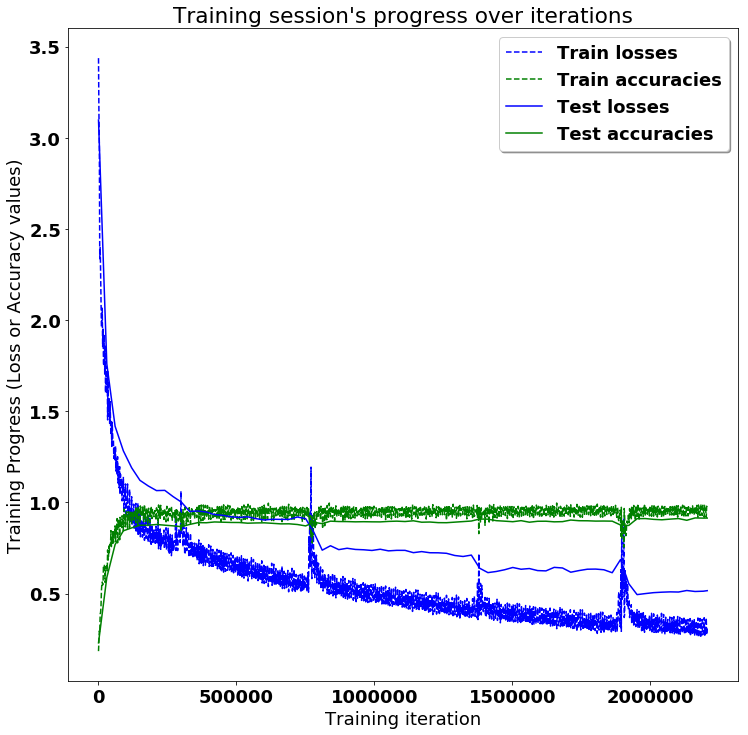

In [10]:
# (Inline plots: )
%matplotlib inline

font = {
    'family' : 'Bitstream Vera Sans',
    'weight' : 'bold',
    'size'   : 18
}
matplotlib.rc('font', **font)

width = 12
height = 12
plt.figure(figsize=(width, height))

indep_train_axis = np.array(range(batch_size, (len(train_losses)+1)*batch_size, batch_size))
plt.plot(indep_train_axis, np.array(train_losses),     "b--", label="Train losses")
plt.plot(indep_train_axis, np.array(train_accuracies), "g--", label="Train accuracies")

indep_test_axis = np.append(
    np.array(range(batch_size, len(test_losses)*display_iter, display_iter)[:-1]),
    [training_iters]
)
plt.plot(indep_test_axis, np.array(test_losses),     "b-", label="Test losses")
plt.plot(indep_test_axis, np.array(test_accuracies), "g-", label="Test accuracies")

plt.title("Training session's progress over iterations")
plt.legend(loc='upper right', shadow=True)
plt.ylabel('Training Progress (Loss or Accuracy values)')
plt.xlabel('Training iteration')

plt.show()